# **Agricultural Crop Yield**

This dataset contains agricultural data for 1,000,000 samples aimed at predicting crop yield (in tons per hectare) based on various factors. The dataset can be used for regression tasks in machine learning, especially for predicting crop productivity.

- Region: The geographical region where the crop is grown (North, East, South, West).

- Soil_Type: The type of soil in which the crop is planted (Clay, Sandy, Loam, Silt, Peaty, Chalky).

- Crop: The type of crop grown (Wheat, Rice, Maize, Barley, Soybean, Cotton).

- Rainfall_mm: The amount of rainfall received in millimeters during the crop growth period.

- Temperature_Celsius: The average temperature during the crop growth period, measured in degrees Celsius.

- Fertilizer_Used: Indicates whether fertilizer was applied (True = Yes, False = No).

- Irrigation_Used: Indicates whether irrigation was used during the crop growth period (True = Yes, False = No).

- Weather_Condition: The predominant weather condition during the growing season (Sunny, Rainy, Cloudy).

- Days_to_Harvest: The number of days taken for the crop to be harvested after planting.

- Yield_tons_per_hectare: The total crop yield produced, measured in tons per hectare.

In [2]:
# import relevant libraries
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
from pyod.models.knn import KNN
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error, mean_squared_error
from scipy.stats import pearsonr
from scipy.stats import jarque_bera
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")

## **1. Data Exploration**

In [3]:
# load the dataset
crop_yield_df = pd.read_csv("crop_yield.csv")

In [4]:
# display the data info 
crop_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


In [5]:
# display the first five rows 
crop_yield_df.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [6]:
# count the number of empty values for each column 
crop_yield_df.isnull().sum()

Region                    0
Soil_Type                 0
Crop                      0
Rainfall_mm               0
Temperature_Celsius       0
Fertilizer_Used           0
Irrigation_Used           0
Weather_Condition         0
Days_to_Harvest           0
Yield_tons_per_hectare    0
dtype: int64

In [7]:
# count the total number of duplicated rows
crop_yield_df.duplicated().sum()

np.int64(0)

In [8]:
# rename the columns
crop_yield_df.rename(columns = {'Region': 'region', 
                                'Soil_Type': 'soil_type', 
                                'Crop': 'crop', 
                                'Rainfall_mm': 'rainfall', 
                                'Temperature_Celsius': 'temperature', 
                                'Fertilizer_Used': 'fertilizer', 
                                'Irrigation_Used': 'irrigation', 
                                'Weather_Condition': 'weather_condition', 
                                'Days_to_Harvest': 'days_to_harvest', 
                                'Yield_tons_per_hectare': 'crop_yield'}, inplace = True)
crop_yield_df.head()

,region,soil_type,crop,rainfall,temperature,fertilizer,irrigation,weather_condition,days_to_harvest,crop_yield
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [9]:
# display the descriptive statistics
crop_yield_df.describe(include = "all")

,region,soil_type,crop,rainfall,temperature,fertilizer,irrigation,weather_condition,days_to_harvest,crop_yield
count,1000000,1000000,1000000,1000000.000000,1000000.000000,1000000,1000000,1000000,1000000.000000,1000000.000000
unique,4,6,6,NaN,NaN,2,2,3,NaN,NaN
top,North,Sandy,Maize,NaN,NaN,False,False,Sunny,NaN,NaN
freq,250173,167119,166824,NaN,NaN,500060,500509,333790,NaN,NaN
mean,NaN,NaN,NaN,549.981901,27.504965,NaN,NaN,NaN,104.495025,4.649472
std,NaN,NaN,NaN,259.851320,7.220608,NaN,NaN,NaN,25.953412,1.696572
min,NaN,NaN,NaN,100.000896,15.000034,NaN,NaN,NaN,60.000000,-1.147613
25%,NaN,NaN,NaN,324.891090,21.254502,NaN,NaN,NaN,82.000000,3.417637
50%,NaN,NaN,NaN,550.124061,27.507365,NaN,NaN,NaN,104.000000,4.651808
75%,NaN,NaN,NaN,774.738520,33.753267,NaN,NaN,NaN,127.000000,5.879200


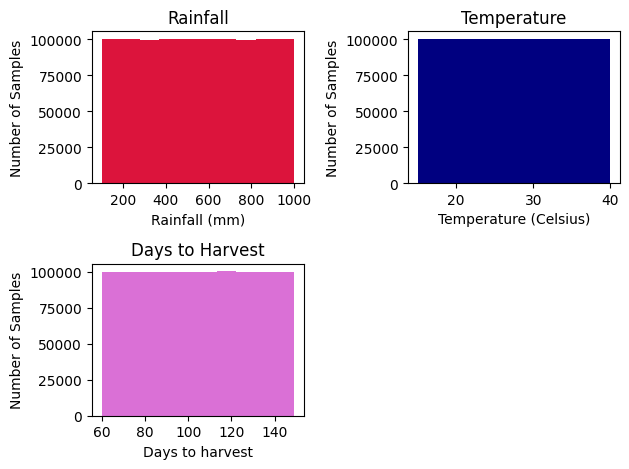

In [10]:
# visualize of distribution of rainfall, temperature, days_to_harvest
plt.subplot(2, 2, 1)
crop_yield_df['rainfall'].plot(kind = "hist", color = "crimson")
plt.title("Rainfall")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Number of Samples")

plt.subplot(2, 2, 2)
crop_yield_df['temperature'].plot(kind = "hist", color = "navy")
plt.title("Temperature")
plt.xlabel("Temperature (Celsius)")
plt.ylabel("Number of Samples")

plt.subplot(2, 2, 3)
crop_yield_df['days_to_harvest'].plot(kind = "hist", color = "orchid")
plt.title("Days to Harvest")
plt.xlabel("Days to harvest")
plt.ylabel("Number of Samples")

plt.tight_layout()
plt.show()

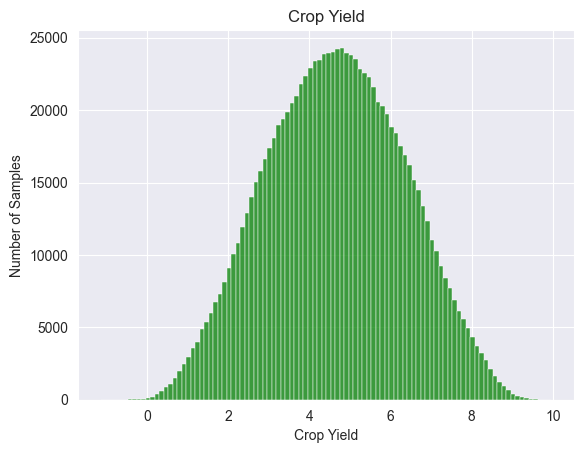

In [11]:
# visualize the distribution of crop yield
sns.set_style("darkgrid")
sns.histplot(x = "crop_yield", bins = 100, data = crop_yield_df, color = "green")
plt.title("Crop Yield")
plt.xlabel("Crop Yield")
plt.ylabel("Number of Samples")
plt.show()

231
0


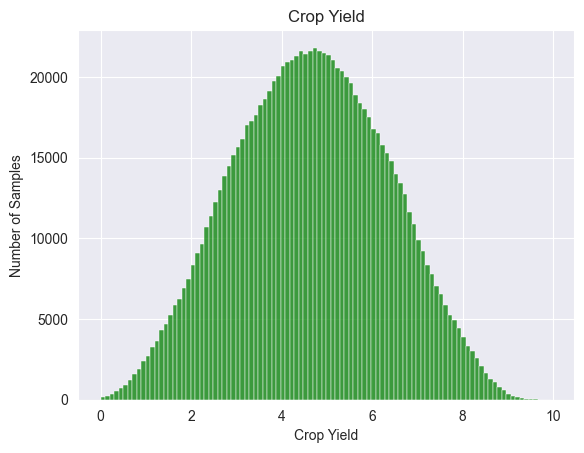

In [12]:
# count the number of data with crop yield that is in negative
print(len(crop_yield_df[crop_yield_df['crop_yield'] < 0]))

# remove the row with crop yield (measured in tons per hectare) that is in negative
crop_yield_df = crop_yield_df[crop_yield_df['crop_yield'] > 0]

# count the number of data with crop yield that is in negative 
print(len(crop_yield_df[crop_yield_df['crop_yield'] < 0]))

# visualize the distribution of crop yield after removal of negative values
sns.set_style("darkgrid")
sns.histplot(x = "crop_yield", bins = 100, data = crop_yield_df, color = "green")
plt.title("Crop Yield")
plt.xlabel("Crop Yield")
plt.ylabel("Number of Samples")
plt.show()

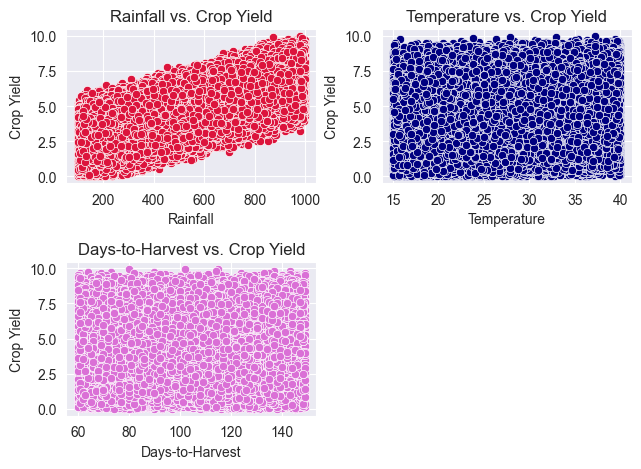

In [13]:
# visualize the relationship of the numerical features with the crop yield 
plt.subplot(2, 2, 1)
sns.scatterplot(x = "rainfall", y = "crop_yield", color = "crimson", data = crop_yield_df)
plt.title("Rainfall vs. Crop Yield")
plt.xlabel("Rainfall")
plt.ylabel("Crop Yield")

plt.subplot(2, 2, 2)
sns.scatterplot(x = "temperature", y = "crop_yield", color = "navy", data = crop_yield_df)
plt.title("Temperature vs. Crop Yield")
plt.xlabel("Temperature")
plt.ylabel("Crop Yield")

plt.subplot(2, 2, 3)
sns.scatterplot(x = "days_to_harvest", y = "crop_yield", color = "orchid", data = crop_yield_df)
plt.title("Days-to-Harvest vs. Crop Yield")
plt.xlabel("Days-to-Harvest")
plt.ylabel("Crop Yield")

plt.tight_layout()
plt.show()

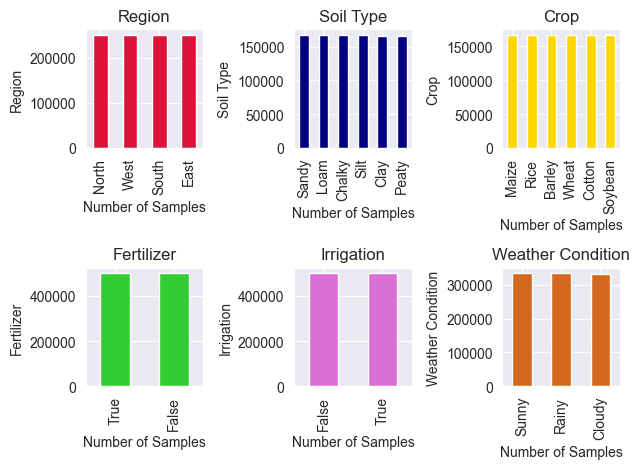

In [14]:
# visualize the distribution of region, soil type, crop, fertilizer, irrigation, weather condition
plt.subplot(2, 3, 1)
crop_yield_df['region'].value_counts().plot(kind = "bar", color = "crimson")
plt.title("Region")
plt.xlabel("Number of Samples")
plt.ylabel("Region")

plt.subplot(2, 3, 2)
crop_yield_df['soil_type'].value_counts().plot(kind = "bar", color = "navy")
plt.title("Soil Type")
plt.xlabel("Number of Samples")
plt.ylabel("Soil Type")

plt.subplot(2, 3, 3)
crop_yield_df['crop'].value_counts().plot(kind = "bar", color = "gold")
plt.title("Crop")
plt.xlabel("Number of Samples")
plt.ylabel("Crop")

plt.subplot(2, 3, 4)
crop_yield_df['fertilizer'].value_counts().plot(kind = "bar", color = "limegreen")
plt.title("Fertilizer")
plt.xlabel("Number of Samples")
plt.ylabel("Fertilizer")

plt.subplot(2, 3, 5)
crop_yield_df['irrigation'].value_counts().plot(kind = "bar", color = "orchid")
plt.title("Irrigation")
plt.xlabel("Number of Samples")
plt.ylabel("Irrigation")

plt.subplot(2, 3, 6)
crop_yield_df['weather_condition'].value_counts().plot(kind = "bar", color = "chocolate")
plt.title("Weather Condition")
plt.xlabel("Number of Samples")
plt.ylabel("Weather Condition")

plt.tight_layout()
plt.show()

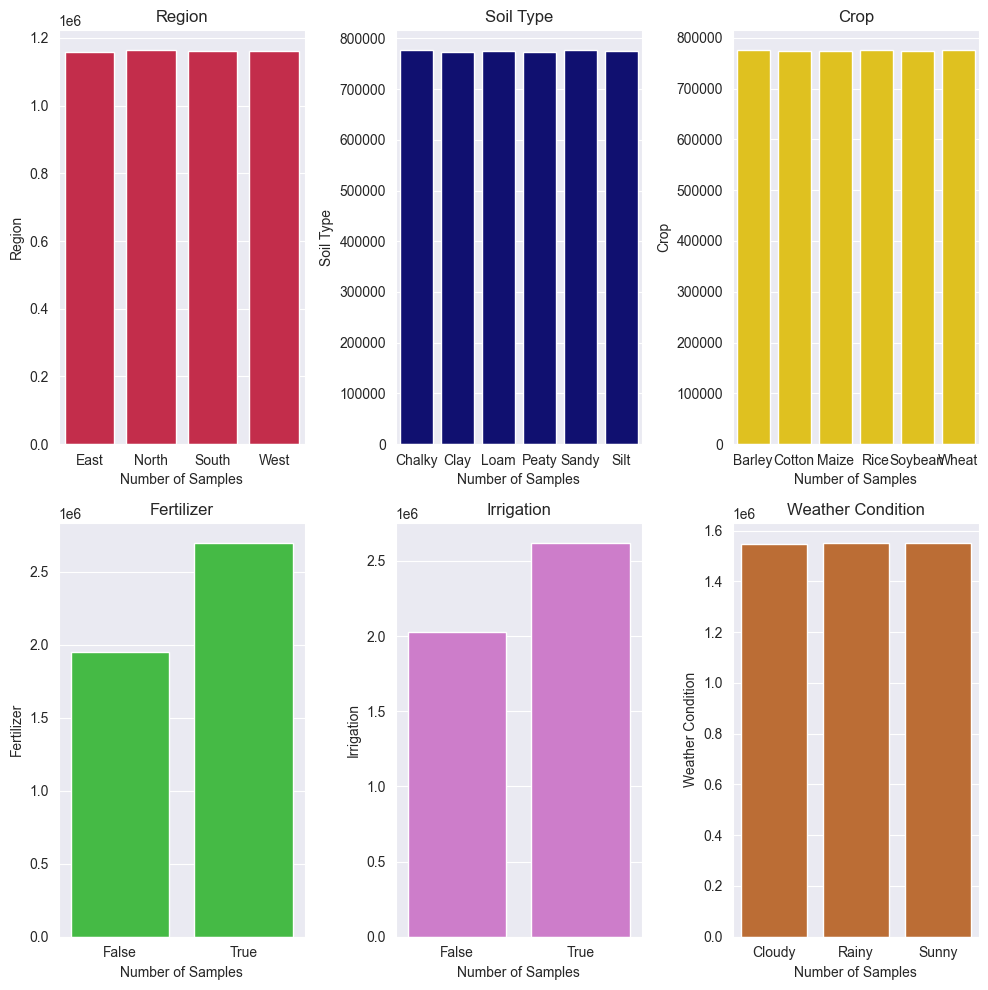

In [15]:
# visualize the relationship of the categorical features with the crop yield 
region = crop_yield_df.groupby(by = "region")['crop_yield'].sum()
soil_type = crop_yield_df.groupby(by = "soil_type")['crop_yield'].sum()
crop = crop_yield_df.groupby(by = "crop")['crop_yield'].sum()
fertilizer = crop_yield_df.groupby(by = "fertilizer")['crop_yield'].sum()
irrigation = crop_yield_df.groupby(by = "irrigation")['crop_yield'].sum()
weather_condition = crop_yield_df.groupby(by = "weather_condition")['crop_yield'].sum()

plt.figure(figsize = (10, 10))
plt.subplot(2, 3, 1)
sns.barplot(region, color = "crimson")
plt.title("Region")
plt.xlabel("Number of Samples")
plt.ylabel("Region")

plt.subplot(2, 3, 2)
sns.barplot(soil_type, color = "navy")
plt.title("Soil Type")
plt.xlabel("Number of Samples")
plt.ylabel("Soil Type")

plt.subplot(2, 3, 3)
sns.barplot(crop, color = "gold")
plt.title("Crop")
plt.xlabel("Number of Samples")
plt.ylabel("Crop")

plt.subplot(2, 3, 4)
sns.barplot(fertilizer, color = "limegreen")
plt.title("Fertilizer")
plt.xlabel("Number of Samples")
plt.ylabel("Fertilizer")

plt.subplot(2, 3, 5)
sns.barplot(irrigation, color = "orchid")
plt.title("Irrigation")
plt.xlabel("Number of Samples")
plt.ylabel("Irrigation")

plt.subplot(2, 3, 6)
sns.barplot(weather_condition, color = "chocolate")
plt.title("Weather Condition")
plt.xlabel("Number of Samples")
plt.ylabel("Weather Condition")

plt.tight_layout()
plt.show()

## **2. Outlier Analysis - KNN**

In [16]:
# extract the X-features 
x_knn = crop_yield_df.drop(['crop_yield'], axis = 1)
x_knn.head()

,region,soil_type,crop,rainfall,temperature,fertilizer,irrigation,weather_condition,days_to_harvest
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110


In [17]:
# standardize the numerical features
scaler = StandardScaler()
x_knn[['rainfall', 'temperature', 'days_to_harvest']] = scaler.fit_transform(x_knn[['rainfall', 'temperature', 'days_to_harvest']])
x_knn.head()

,region,soil_type,crop,rainfall,temperature,fertilizer,irrigation,weather_condition,days_to_harvest
0,West,Sandy,Cotton,1.335619,0.023667,False,True,Cloudy,0.674475
1,South,Clay,Rice,1.703573,-1.312923,True,True,Rainy,1.368028
2,North,Loam,Barley,-1.547626,0.316871,False,False,Sunny,0.057983
3,North,Sandy,Soybean,1.681222,-1.504316,False,True,Rainy,1.599212
4,South,Silt,Wheat,0.693989,0.569852,True,True,Cloudy,0.212106


In [18]:
# encode the categorical features
x_knn['region'] = x_knn['region'].map({'East': 0, 'North': 1, 'South': 2, 'West': 3})
x_knn['soil_type'] = x_knn['soil_type'].map({'Chalky': 0, 'Clay': 1, 'Loam': 2, 'Peaty': 3, 'Sandy': 4, 'Silt': 5})
x_knn['crop'] = x_knn['crop'].map({'Barley': 0, 'Cotton': 1, 'Maize': 2, 'Rice': 3, 'Soybean': 4, 'Wheat': 5})
x_knn['fertilizer'] = x_knn['fertilizer'].map({False: 0, True: 1})
x_knn['irrigation'] = x_knn['irrigation'].map({False: 0, True: 1})
x_knn['weather_condition'] = x_knn['weather_condition'].map({'Cloudy': 0, 'Rainy': 1, 'Sunny': 2})
x_knn.head()

,region,soil_type,crop,rainfall,temperature,fertilizer,irrigation,weather_condition,days_to_harvest
0,3,4,1,1.335619,0.023667,0,1,0,0.674475
1,2,1,3,1.703573,-1.312923,1,1,1,1.368028
2,1,2,0,-1.547626,0.316871,0,0,2,0.057983
3,1,4,4,1.681222,-1.504316,0,1,1,1.599212
4,2,5,5,0.693989,0.569852,1,1,0,0.212106


In [19]:
# train the knn
knn_model = KNN(n_neighbors = 5)
knn_model.fit(x_knn)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [20]:
# perform predictions 
knn_y_pred = knn_model.predict(x_knn)

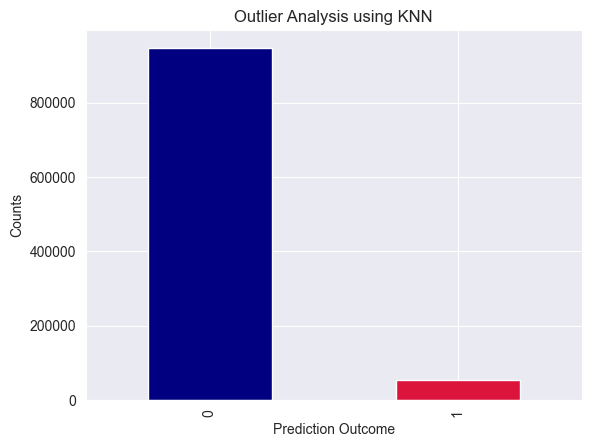

In [21]:
# visualize the number of outliers and inliers 
sns.set_style("darkgrid")
pd.Series(knn_y_pred).value_counts().plot(kind = "bar", color = ['navy', 'crimson'])
plt.title("Outlier Analysis using KNN")
plt.xlabel("Prediction Outcome")
plt.ylabel("Counts")
plt.show()

In [22]:
# remove the outliers (i.e. outlier = 1)
outlier_indices = np.where(knn_y_pred == 1)[0]

In [23]:
# remove outliers from the original data
newData = np.delete(crop_yield_df, outlier_indices, axis = 0)

In [24]:
# get the column names
colNames = crop_yield_df.columns
# place the outliers remove data into a new Dataframe
crop_yield_df = pd.DataFrame(newData, columns = colNames)
crop_yield_df.head()

,region,soil_type,crop,rainfall,temperature,fertilizer,irrigation,weather_condition,days_to_harvest,crop_yield
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251
4,South,Silt,Soybean,797.471182,37.704974,False,True,Rainy,74,5.898416


## **3. Feature Selection using Inferential Statistics**

### 3.1 Pearson Correlation

In [25]:
crop_yield_df.crop_yield

0         6.555816
1         8.527341
2         1.127443
3         7.248251
4         5.898416
            ...   
947162    1.347586
947163    7.311594
947164    5.763182
947165    2.070159
947166    2.937243
Name: crop_yield, Length: 947167, dtype: object

In [26]:
# relationship between the rainfall and crop yield 
pearsonr(list(crop_yield_df.rainfall), list(crop_yield_df.crop_yield))
# p-value = 0.000 < 5%, reject the null hypothesis. 
# Hence, there is a relationship between the rainfall and crop yield 

PearsonRResult(statistic=np.float64(0.7586014180509705), pvalue=np.float64(0.0))

In [27]:
# relationship between the temperature and crop yield 
pearsonr(list(crop_yield_df.temperature), list(crop_yield_df.crop_yield))
# p-value = 0.000 < 5%, reject the null hypothesis. 
# Hence, there is a relationship between the temperature and crop yield 

PearsonRResult(statistic=np.float64(0.08514810978080217), pvalue=np.float64(0.0))

In [28]:
# relationship between the days to harvest and crop yield 
pearsonr(list(crop_yield_df.days_to_harvest), list(crop_yield_df.crop_yield))
# p-value = 0.000 < alpha = 5%, reject the null hypothesis. 
# Hence, there is a relationship between the days to harvest and crop yield 

PearsonRResult(statistic=np.float64(-0.0036467491688565675), pvalue=np.float64(0.0003865285831086393))

### 3.2. ANOVA/Kruskal-Wallis Test

#### 3.2.1. Region

In [29]:
# using shapiro test to check the normality assumption for each group
west_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.region == 'West']['crop_yield'])
south_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.region == 'South']['crop_yield'])
north_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.region == 'North']['crop_yield'])
east_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.region == 'East']['crop_yield'])

print(jarque_bera(west_crop_yield))
print(jarque_bera(south_crop_yield))
print(jarque_bera(north_crop_yield))
print(jarque_bera(east_crop_yield))
# p-vlaue = 0 < alpha = 5%, reject null hypothesis. 
# Hence, the normality assumption is violated 

SignificanceResult(statistic=np.float64(2634.1938071901936), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(2592.2675744409444), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(2533.3481582046543), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(2668.1451531144835), pvalue=np.float64(0.0))


In [30]:
# using levene test to check for equal variance assumption 
print(levene(west_crop_yield, south_crop_yield, north_crop_yield, east_crop_yield))
# p-value = 0.905 > alpha = 5%, failed to reject null hypothesis. 
# Hence, all groups have a equal variance. 

LeveneResult(statistic=np.float64(0.18768201604527499), pvalue=np.float64(0.9048374838959921))


In [31]:
# using Kruskall-Wallis Test to check the relationship between region and crop yield 
print(kruskal(west_crop_yield, south_crop_yield, north_crop_yield, east_crop_yield))
# p-value = 0.108 > alpha = 5%, failed to reject null hypothesis. 
# Hence, there is no statistically significant difference in crop yield across different region. 

KruskalResult(statistic=np.float64(6.074402044527233), pvalue=np.float64(0.10804598239787941))


#### 3.2.2. Soil Type

In [32]:
# using shapiro test to check the normality assumption for each group
sandy_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.soil_type == 'Sandy']['crop_yield'])
loam_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.soil_type == 'Loam']['crop_yield'])
silt_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.soil_type == 'Silt']['crop_yield'])
chalky_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.soil_type == 'Chalky']['crop_yield'])
clay_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.soil_type == 'Clay']['crop_yield'])
peaty_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.soil_type == 'Peaty']['crop_yield'])

print(jarque_bera(sandy_crop_yield))
print(jarque_bera(loam_crop_yield))
print(jarque_bera(silt_crop_yield))
print(jarque_bera(chalky_crop_yield))
print(jarque_bera(clay_crop_yield))
print(jarque_bera(peaty_crop_yield))
# p-vlaue = 0 < alpha = 5%, reject null hypothesis,. 
# Hence, the normality assumption is violated 

SignificanceResult(statistic=np.float64(1744.9938297249246), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(1711.8235360253625), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(1712.733535431605), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(1727.9850422388693), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(1718.9346419747149), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(1814.4402122007673), pvalue=np.float64(0.0))


In [33]:
# using levene test to check for equal variance assumption 
print(levene(sandy_crop_yield, loam_crop_yield, silt_crop_yield, chalky_crop_yield, clay_crop_yield, peaty_crop_yield))
# p-value = 0.842 > alpha = 5%, failed to reject null hypothesis. 
# Hence, all groups have a equal variance. 

LeveneResult(statistic=np.float64(0.41009877939482575), pvalue=np.float64(0.8421149186881901))


In [34]:
# using Kruskall-Wallis Test to check the relationship between soil type and crop yield 
print(kruskal(sandy_crop_yield, loam_crop_yield, silt_crop_yield, chalky_crop_yield, clay_crop_yield, peaty_crop_yield))
# p-value = 0.753 > alpha = 5%, failed to reject null hypothesis. 
# Hence, there is no statistically significant difference in crop yield across different soil type. 

KruskalResult(statistic=np.float64(2.656355441082269), pvalue=np.float64(0.752785154504919))


#### 3.2.3. Crop

In [35]:
# using shapiro test to check the normality assumption for each group
maize_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.crop == 'Maize']['crop_yield'])
rice_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.crop == 'Rice']['crop_yield'])
wheat_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.crop == 'Wheat']['crop_yield'])
barley_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.crop == 'Barley']['crop_yield'])
cotton_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.crop == 'Cotton']['crop_yield'])
soybean_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.crop == 'Soybean']['crop_yield'])

print(jarque_bera(maize_crop_yield))
print(jarque_bera(rice_crop_yield))
print(jarque_bera(wheat_crop_yield))
print(jarque_bera(barley_crop_yield))
print(jarque_bera(cotton_crop_yield))
print(jarque_bera(soybean_crop_yield))
# p-vlaue = 0 < alpha = 5%, reject null hypothesis,. 
# Hence, the normality assumption is violated 

SignificanceResult(statistic=np.float64(1765.1267469271243), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(1698.870426363412), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(1645.7533969806543), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(1823.9254283423395), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(1795.5286788780447), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(1701.9995152754257), pvalue=np.float64(0.0))


In [36]:
# using levene test to check for equal variance assumption 
print(levene(maize_crop_yield, rice_crop_yield, wheat_crop_yield, barley_crop_yield, cotton_crop_yield, soybean_crop_yield))
# p-value = 0.760 > alpha = 5%, failed to reject null hypothesis. 
# Hence, all groups have a equal variance. 

LeveneResult(statistic=np.float64(0.5218381827300496), pvalue=np.float64(0.7599682490341025))


In [37]:
# using Kruskall-Wallis Test to check the relationship between crop type and crop yield 
print(kruskal(maize_crop_yield, rice_crop_yield, wheat_crop_yield, barley_crop_yield, cotton_crop_yield, soybean_crop_yield))
# p-value = 0.320 > alpha = 5%, failed to reject null hypothesis. 
# Hence, there is no statistically significant difference in crop yield across different the crop type. 

KruskalResult(statistic=np.float64(5.865617155097425), pvalue=np.float64(0.31951538259788553))


#### 3.2.4. Weather Condition

In [38]:
# using shapiro test to check the normality assumption for each group
rainy_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.weather_condition == 'Rainy']['crop_yield'])
sunny_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.weather_condition == 'Sunny']['crop_yield'])
cloudy_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.weather_condition == 'Cloudy']['crop_yield'])

print(jarque_bera(rainy_crop_yield))
print(jarque_bera(sunny_crop_yield))
print(jarque_bera(cloudy_crop_yield))

# p-vlaue = 0 < alpha = 5%, reject null hypothesis. 
# Hence, the normality assumption is violated 

SignificanceResult(statistic=np.float64(3438.1312694727408), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(3433.7232194068883), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(3556.4505470907875), pvalue=np.float64(0.0))


In [39]:
# using levene test to check for equal variance assumption 
print(levene(rainy_crop_yield, sunny_crop_yield, cloudy_crop_yield))
# p-value = 0.602 > alpha = 5%, failed to reject null hypothesis. 
# Hence, all groups have a equal variance. 

LeveneResult(statistic=np.float64(0.6015285211587822), pvalue=np.float64(0.5479736158756612))


In [40]:
# using Kruskall-Wallis Test to check the relationship between weather condition and crop yield 
print(kruskal(rainy_crop_yield, sunny_crop_yield, cloudy_crop_yield))
# p-value = 0.245 > alpha = 5%, failed to reject null hypothesis. 
# Hence, there is no statistically significant difference between in crop yield across different weather conditions.  

KruskalResult(statistic=np.float64(2.8100038333795965), pvalue=np.float64(0.24536658616084311))


### 3.3. Indepedent t-test/ Wilcoxon rank-sum test

#### 3.3.1. Fertilizer

In [41]:
# using shapiro test to check the normality assumption for each group
true_fertilizer_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.fertilizer == True]['crop_yield'])
false_fertilizer_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.fertilizer == False]['crop_yield'])

print(jarque_bera(true_fertilizer_crop_yield))
print(jarque_bera(false_fertilizer_crop_yield))

# p-vlaue = 0 < alpha = 5%, reject null hypothesis,. 
# Hence, the normality assumption is violated 

SignificanceResult(statistic=np.float64(8867.073637691676), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(9120.026521021568), pvalue=np.float64(0.0))


In [42]:
# using levene test to check for equal variance assumption 
print(levene(true_fertilizer_crop_yield, false_fertilizer_crop_yield))
# p-value = 0.345 > alpha = 5%, failed to reject null hypothesis. 
# Hence, all groups have a equal variance. 

LeveneResult(statistic=np.float64(0.8924645765168802), pvalue=np.float64(0.34481054477841333))


In [43]:
# using Wilcoxon Test to check the relationship between fertilizer and crop yield 
print(mannwhitneyu(true_fertilizer_crop_yield, false_fertilizer_crop_yield))
# p-value = 0.000 < alpha = 5%, so 4we reject null hypothesis. 
# Hence, there is a statistically significant difference in crop yield between fertilizer and non-fertilizer. 

MannwhitneyuResult(statistic=np.float64(168575392685.0), pvalue=np.float64(0.0))


#### 3.3.1. Irrigation

In [44]:
# using shapiro test to check the normality assumption for each group
true_irrigation_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.irrigation == True]['crop_yield'])
false_irrigation_crop_yield = pd.to_numeric(crop_yield_df[crop_yield_df.irrigation == False]['crop_yield'])

print(jarque_bera(true_irrigation_crop_yield))
print(jarque_bera(false_irrigation_crop_yield))

# p-vlaue = 0 < alpha = 5%, reject null hypothesis,. 
# Hence, the normality assumption is violated 

SignificanceResult(statistic=np.float64(7663.752441620485), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(8021.813514656498), pvalue=np.float64(0.0))


In [45]:
# using levene test to check for equal variance assumption 
print(levene(true_irrigation_crop_yield, false_irrigation_crop_yield))
# p-value = 0.464s > alpha = 5%, failed to reject null hypothesis. 
# Hence, all groups have a equal variance. 

LeveneResult(statistic=np.float64(0.5354455668005486), pvalue=np.float64(0.4643265656088845))


In [46]:
# using Wilcoxon Test to check the relationship between irrigation and crop yield 
print(mannwhitneyu(true_irrigation_crop_yield, false_irrigation_crop_yield))
# p-value = 0.000 < alpha = 5%, so we reject null hypothesis. 
# Hence, there is a statistically significant difference in crop yield between irrigation and non-irrigation. 

MannwhitneyuResult(statistic=np.float64(156681738267.0), pvalue=np.float64(0.0))


Feature Selected: rainfall, temperature, days to harvest, fertilizer, irrigation, 

## **4. Model Building - Artificial Neural Network**

In [47]:
# split the dataset into 70% training and 30% testing 
X_train, X_test, y_train, y_test = train_test_split(crop_yield_df[['rainfall', 'temperature', 'days_to_harvest', 'fertilizer', 'irrigation']], 
                                                    crop_yield_df['crop_yield'], 
                                                    test_size = 0.3, 
                                                    shuffle = True, 
                                                    random_state = 2025)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(663016, 5)
(284151, 5)
(663016,)
(284151,)


In [48]:
# standardize the numerical features
scaler = StandardScaler()
X_train[['rainfall', 'temperature', 'days_to_harvest']] = scaler.fit_transform(X_train[['rainfall', 'temperature', 'days_to_harvest']])
X_test[['rainfall', 'temperature', 'days_to_harvest']] = scaler.transform(X_test[['rainfall', 'temperature', 'days_to_harvest']])

In [49]:
# encode the categorical features
X_train['fertilizer'] = X_train['fertilizer'].map({False: 0, True: 1})
X_train['irrigation'] = X_train['irrigation'].map({False: 0, True: 1})
X_test['fertilizer'] = X_test['fertilizer'].map({False: 0, True: 1})
X_test['irrigation'] = X_test['irrigation'].map({False: 0, True: 1})

In [50]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [58]:
def root_mean_square_log_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1))))

def baseModel():
    model = Sequential()
    model.add(Dense(64, input_dim = X_train.shape[1], activation = "gelu"))
    model.add(Dropout(0.15))
    model.add(Dense(32, activation = "gelu"))
    model.add(Dropout(0.15))
    model.add(Dense(1, activation = "relu"))
    #model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = [root_mean_square_log_error])
    return model

base_model = KerasRegressor(model = baseModel, 
                            epochs = 10, 
                            batch_size = 512, 
                            shuffle = True, 
                            verbose = 1, 
                            compile__loss = "mean_squared_error", 
                            compile__optimizer = "adam", 
                            compile__metrics = [root_mean_square_log_error],
                            random_state = 2025)

with tf.device("/GPU:0"):
    base_model_res = base_model.fit(X_train, y_train, validation_split = 0.2)

Epoch 1/10


2025-06-04 12:34:40.658357: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 12:34:40.659798: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.8511 - root_mean_square_log_error: 0.6755 - val_loss: 0.2539 - val_root_mean_square_log_error: 0.4512
Epoch 2/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4956 - root_mean_square_log_error: 0.4562 - val_loss: 0.2540 - val_root_mean_square_log_error: 0.4494
Epoch 3/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4341 - root_mean_square_log_error: 0.4551 - val_loss: 0.2511 - val_root_mean_square_log_error: 0.4513
Epoch 4/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4019 - root_mean_square_log_error: 0.4553 - val_loss: 0.2527 - val_root_mean_square_log_error: 0.4504
Epoch 5/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3784 - root_mean_square_log_error: 0.4552 - val_loss: 0.2531 - val_root_mean_square_log_error: 0.4503
Epoch 6/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3581 - root_mean_square_log_error: 0.4544 - val_loss: 0.2534 - val_root_mean_square_log_error: 0.4514
Epoch 7/10
1036

## **5. Model Evaluation**

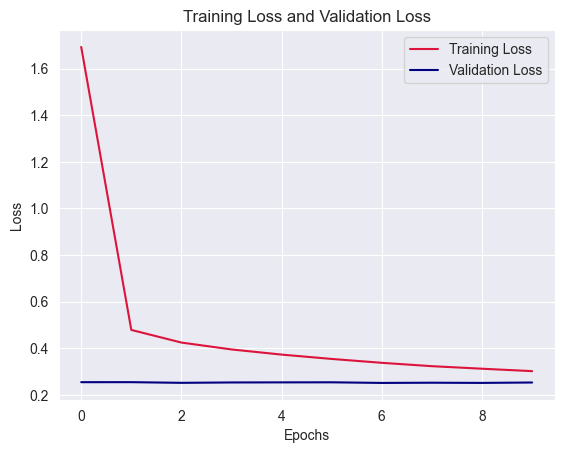

In [59]:
# plot the loss curves 
sns.lineplot(base_model.history_['loss'], color = "crimson", label = "Training Loss")
sns.lineplot(base_model.history_['val_loss'], color = "navy", label = "Validation Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

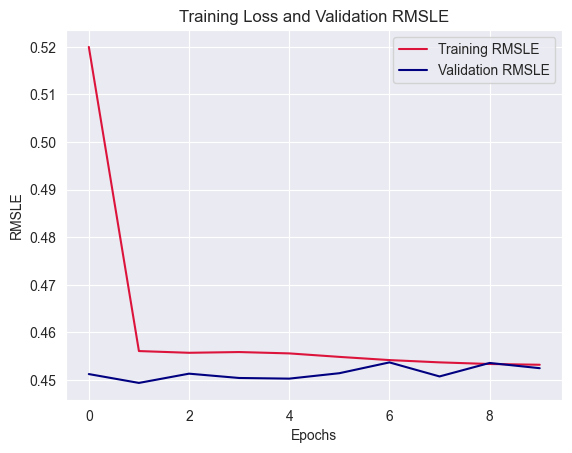

In [60]:
# plot the RMSLE curves 
sns.lineplot(base_model.history_['root_mean_square_log_error'], color = "crimson", label = "Training RMSLE")
sns.lineplot(base_model.history_['val_root_mean_square_log_error'], color = "navy", label = "Validation RMSLE")
plt.title("Training Loss and Validation RMSLE")
plt.xlabel("Epochs")
plt.ylabel("RMSLE")
plt.show()

In [61]:
# prediction on train and test data
y_pred_train = base_model.predict(X_train)
y_pred_test = base_model.predict(X_test)

 278/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step

2025-06-04 12:35:10.445976: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-04 12:35:10.446345: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


In [62]:
# evaluate the baseline model based on R2, RMSLE, MAE
train_r2_score = r2_score(y_train, y_pred_train)
train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)

test_r2_score = r2_score(y_test, y_pred_test)
test_rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

base_model_eval = {'Train': {'R2': train_r2_score, 'RMSLE': train_rmsle, 'MAE': train_mae}, 
                   'Test': {'R2': test_r2_score, 'RMSLE': test_rmsle, 'MAE': test_mae}}

base_model_eval = pd.DataFrame(base_model_eval)
base_model_eval

,Train,Test
R2,0.910086,0.909483
RMSLE,0.105570,0.105655
MAE,0.401482,0.402029


In [ ]:
# cross-validation 
with tf.device("/GPU:0"):
    r2_scores_train = []
    rmsle_train = []
    mae_train = []

    r2_scores_val = []
    rmsle_val = []
    mae_val = []

    kf = KFold(n_splits = 5, shuffle = True, random_state = 2025)
    for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        print("\n-- Fold {}/{} --".format(fold + 1, kf.n_splits))

        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        fold_model = KerasRegressor(model = baseModel, 
                                    epochs = 10, 
                                    batch_size = 512, 
                                    shuffle = True, 
                                    verbose = 1, 
                                    compile__loss = "mean_squared_error", 
                                    compile__optimizer = "adam", 
                                    compile__metrics = [root_mean_square_log_error],
                                    random_state = 2025)
        fold_model.fit(X_train_fold, y_train_fold)

        # eval based on train set
        y_pred_fold_train = fold_model.predict(X_train_fold)
        r2_scores_train.append(r2_score(y_train_fold, y_pred_fold_train))
        rmsle_train.append(np.sqrt(mean_squared_log_error(y_train_fold, y_pred_fold_train)))
        mae_train.append(mean_absolute_error(y_train_fold, y_pred_fold_train))

        # eval based on val set 
        y_pred_fold_val = fold_model.predict(X_val_fold)
        r2_scores_val.append(r2_score(y_val_fold, y_pred_fold_val))
        rmsle_val.append(np.sqrt(mean_squared_log_error(y_val_fold, y_pred_fold_val)))
        mae_val.append(mean_absolute_error(y_val_fold, y_pred_fold_val))
        


-- Fold 1/5 --
Epoch 1/10


2025-06-04 12:49:11.012412: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 12:49:11.015249: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8567 - root_mean_square_log_error: 0.6777
Epoch 2/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4932 - root_mean_square_log_error: 0.4579
Epoch 3/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4360 - root_mean_square_log_error: 0.4570
Epoch 4/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3993 - root_mean_square_log_error: 0.4574
Epoch 5/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3764 - root_mean_square_log_error: 0.4572
Epoch 6/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3569 - root_mean_square_log_error: 0.4566
Epoch 7/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3406 - root_mean_square_log_error: 0.4559
Epoch 8/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3245 - root_mean_square_log_error: 0.4553
Epoch 9/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3139 - root_mean_square_log_error: 0.4549
Epoch 10/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - 

2025-06-04 12:49:27.947640: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-04 12:49:27.948162: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step

-- Fold 2/5 --
Epoch 1/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.7932 - root_mean_square_log_error: 0.6735
Epoch 2/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4945 - root_mean_square_log_error: 0.4562
Epoch 3/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4338 - root_mean_square_log_error: 0.4553
Epoch 4/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3976 - root_mean_square_log_error: 0.4555
Epoch 5/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3758 - root_mean_square_log_error: 0.4553
Epoch 6/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3559 - root_mean_square_log_error: 0.4547
Epoch 7/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3389 - root_mean_square_log_error: 0.4540
Epoch 8/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3227 - root_mean_square_log_error: 0.4535
Epoch 9/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms

2025-06-04 12:49:47.163735: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-04 12:49:47.164274: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step

-- Fold 3/5 --
Epoch 1/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.8125 - root_mean_square_log_error: 0.6751
Epoch 2/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4922 - root_mean_square_log_error: 0.4568
Epoch 3/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.4371 - root_mean_square_log_error: 0.4560
Epoch 4/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3987 - root_mean_square_log_error: 0.4563
Epoch 5/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3776 - root_mean_square_log_error: 0.4561
Epoch 6/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3559 - root_mean_square_log_error: 0.4554
Epoch 7/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3400 - root_mean_square_log_error: 0.4548
Epoch 8/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3250 - root_mean_square_log_error: 0.4542
Epoch 9/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms

2025-06-04 12:50:12.479136: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-04 12:50:12.479762: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step

-- Fold 4/5 --
Epoch 1/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.8193 - root_mean_square_log_error: 0.6765
Epoch 2/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4942 - root_mean_square_log_error: 0.4578
Epoch 3/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4355 - root_mean_square_log_error: 0.4568
Epoch 4/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3994 - root_mean_square_log_error: 0.4571
Epoch 5/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3771 - root_mean_square_log_error: 0.4569
Epoch 6/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3573 - root_mean_square_log_error: 0.4562
Epoch 7/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3408 - root_mean_square_log_error: 0.4555
Epoch 8/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3249 - root_mean_square_log_error: 0.4551
Epoch 9/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms

2025-06-04 12:50:31.455327: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-04 12:50:31.455721: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step

-- Fold 5/5 --
Epoch 1/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8206 - root_mean_square_log_error: 0.6742
Epoch 2/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4908 - root_mean_square_log_error: 0.4564
Epoch 3/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4352 - root_mean_square_log_error: 0.4556
Epoch 4/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3996 - root_mean_square_log_error: 0.4558
Epoch 5/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3767 - root_mean_square_log_error: 0.4557
Epoch 6/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3567 - root_mean_square_log_error: 0.4550
Epoch 7/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3404 - root_mean_square_log_error: 0.4544
Epoch 8/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3257 - root_mean_square_log_error: 0.4538
Epoch 9/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms

2025-06-04 12:50:51.194329: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-04 12:50:51.194682: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


In [70]:
cv_dict = {'Train_CV': {'R2': np.mean(r2_scores_train), 'RMSLE': np.mean(rmsle_train), 'MAE': np.mean(mae_train)}, 
                 'Validation_CV': {'R2': np.mean(r2_scores_val), 'RMSLE': np.mean(rmsle_val), 'MAE': np.mean(mae_val)}}

In [71]:
base_model_cv_eval = pd.DataFrame(cv_dict)
base_model_cv_eval

,Train_CV,Validation_CV
R2,0.910936,0.910935
RMSLE,0.105638,0.105632
MAE,0.399624,0.399645
